In [1]:
import matplotlib.font_manager as fm
fm.fontManager.addfont('/home/ubuntu/.config/font/times.ttf')

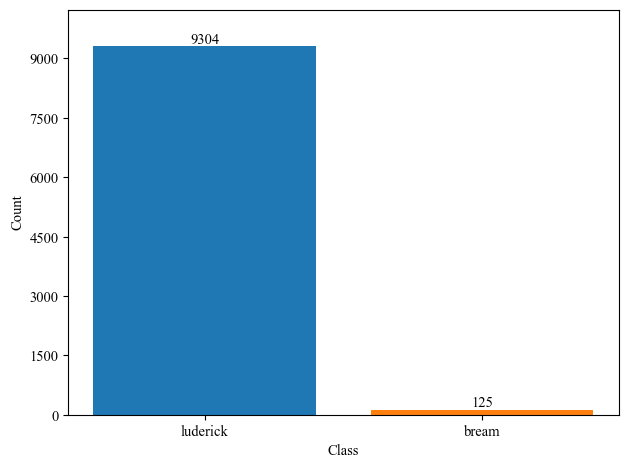

Number of luderick labels = 9304
Number of bream labels = 125


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import math
import matplotlib.font_manager as fm
fm.fontManager.addfont('/home/ubuntu/.config/font/times.ttf')
plt.rc('font',family='Times New Roman', size=10.5)

DATASET_DIR = "./"
IMAGES_DIR = os.path.join(DATASET_DIR, "datasets/luderick-seagrass")
CLASSES = ['background', 'luderick']

luderick_train_df = pd.read_csv(f'{DATASET_DIR}/csv/luderick_seagrass_jack_evans_a.csv')
luderick_val_df = pd.read_csv(f'{DATASET_DIR}/csv/luderick_seagrass_jack_evans_b.csv')
luderick_test_df = pd.read_csv(f'{DATASET_DIR}/csv/luderick_seagrass_tallebudgera.csv')

import matplotlib.pyplot as plt
import numpy as np
plt.rc('font',family='Times New Roman', size=10.5)

num_luderick_train = len(luderick_train_df[luderick_train_df['category'] == 'luderick'])
num_luderick_val = len(luderick_val_df[luderick_val_df['category'] == 'luderick'])
num_luderick_test = len(luderick_test_df[luderick_test_df['category'] == 'luderick'])
num_luderick = num_luderick_train + num_luderick_val + num_luderick_test

num_bream_train = len(luderick_train_df[luderick_train_df['category'] == 'bream'])
num_bream_val = len(luderick_val_df[luderick_val_df['category'] == 'bream'])
num_bream_test = len(luderick_test_df[luderick_test_df['category'] == 'bream'])
num_bream = num_bream_train + num_bream_val + num_bream_test

categories = ['luderick', 'bream']
counts = [num_luderick, num_bream]

fig, ax = plt.subplots()
ax.bar(categories, counts, color=['#1f77b4', '#ff7f0e'])
# ax.set_title('Class counts')
ax.set_xlabel('Class')
ax.set_ylabel('Count')

# 添加数字标签
for i, v in enumerate(counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# 设置柱状图上方的数值显示格式
ax.set_ylim(top=max(counts) * 1.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# 调整图像边距
plt.tight_layout()
plt.savefig('class_counts.svg',dpi=600 ,format='svg')
plt.show()

print(f"Number of luderick labels = {num_luderick}")
print(f"Number of bream labels = {num_bream}")

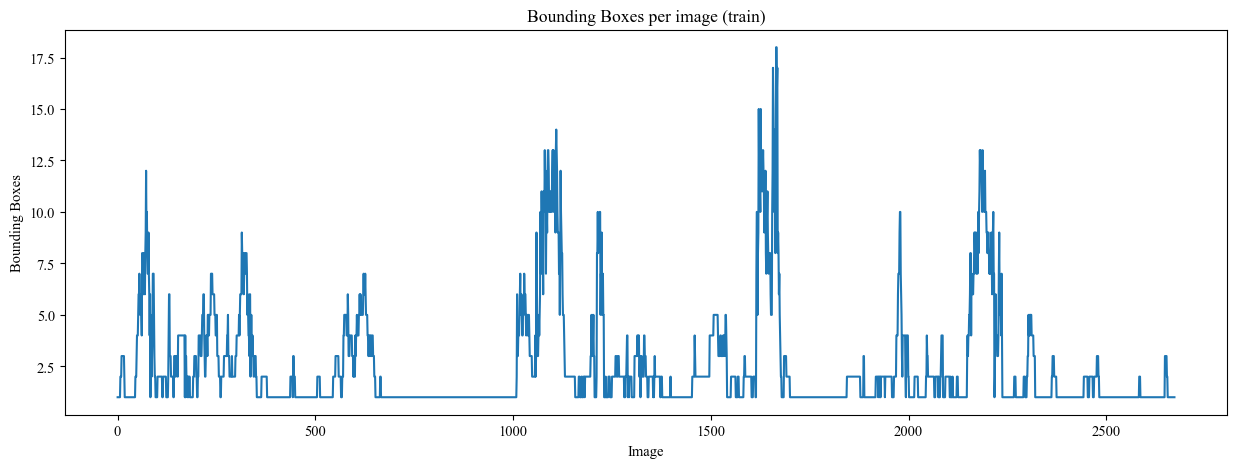

In [4]:
images_list = luderick_train_df['image'].unique()
number_boxes = luderick_train_df.groupby(['image'])["bbox_x"].count().to_list()
plt.figure(figsize=(15, 5))
plt.ylabel('Bounding Boxes')
plt.xlabel('Image')
plt.title('Bounding Boxes per image (train)')
plt.plot(range(len(images_list)), number_boxes)
plt.show()

## Data Preprocessing

As the bream class has only 53 annotated boxes, I will ignore it and **only train the object detection on the luderick class.**


I want the data in the following format to use it on object detection models:

| Column       | Description                                                          |
| ------------ | -------------------------------------------------------------                                                |
| image_name    | STR image file name                                                  |
| video_name     | STR video name  
| frame_number | INT Frame number from its respective video |
| number_boxes | INT number of bounding boxes in the image |
| labels     | ARRAY(INT) class id of each bounding box (1 = luderick, 0 reserved for background)     |
| bounding_boxes      | ARRAY(ARRAY(INT)) list of bounding box coordinates in format [[x_min, y_min, x_max, y_max], ...]       
| area         | ARRAY(INT) area of each bounding box in pixels squared                           |
| segmentation | ARRAY(ARRAY(ARRAY(INT))) segmentation polygon coordinates in format [[[x, y, x, y, ...]], [[x, y,...]]] |

In [ ]:
def get_video_name(image_name):
    """
    Extract the video name from the image name
    """
    if('Luderick' in image_name):
        luderick_index = image_name.index('Luderick')
        # get the video name by removing finding the index of the word Luderick and adding 11 characters for the _xx number
        video_name = image_name[:luderick_index+11]
        # if there's a single number, the last character will be either _ or . and has to be removed
        if video_name[-1] =='_' or video_name[-1] =='.':
            video_name = video_name[:-1]
    else:
        # If Luderick is not in the name, get the string before .mov or .jpg
        video_name = image_name.split('.mov')[0].split('.jpg')[0]
        
    return video_name

In [ ]:
def preprocess_data(luderick_df):
    """
    Convert an original luderick DataFrame to the DataFrame format described above
    """
    # Remove the bream entries from the original dataframe
    luderick_df = luderick_df[luderick_df['category'] == 'luderick']
    # Create the dataframe
    output_df = pd.DataFrame(luderick_df['image'].unique(), columns=['image_name'])
    # get the list of unique images
    images_list = luderick_df['image'].unique()
    # get the list of box numbers
    number_boxes = luderick_df.groupby(['image'])["bbox_x"].count().to_list()
    # get the video names
    output_df['video_name'] = output_df['image_name'].apply(lambda x: get_video_name(x))
    # get the total frames in each video
    frame_numbers = output_df.groupby(['video_name'])["video_name"].count().to_list()
    # get the frame number for each frame in each video
    frame_numbers_array = np.array([np.arange(frames)+1 for frames in frame_numbers], dtype=object)
    # flatten the frame number array
    frame_numbers_array = np.hstack(frame_numbers_array)
    output_df['frame_number'] = frame_numbers_array
    # save the number of boxes
    output_df['number_boxes'] = number_boxes
    
    all_labels = []
    all_boxes = []
    all_areas = []
    all_segmentations = []
    for i, image in enumerate(images_list):
        # get all the rows of the image (frame), each row has info of one bounding box
        image_rows = luderick_df[luderick_df['image'] == image]
        # get all the class labels in the frame
        frame_labels = image_rows['category_id'].values
        # add frame labels to total label list
        all_labels.append(frame_labels)
        
        # get all the bounding boxes
        frame_boxes = image_rows[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values
        # fix annotation errors where bbox coordinates are negative or higher than the image resolution
        frame_boxes[:, 0] = np.clip(frame_boxes[:, 0], 0, 1920).tolist()
        frame_boxes[:, 1] = np.clip(frame_boxes[:, 1], 0, 1080).tolist()
        # convert the bbox_w and bbox_h to x_max and y_max by adding those to bbox_x and bbox_y
        frame_boxes[:, 2] += frame_boxes[:, 0]
        frame_boxes[:, 3] += frame_boxes[:, 1]
        # fix annotation errors (there's at least one case of a coordinate at 1921 after adding the width)
        frame_boxes[:, 2] = np.clip(frame_boxes[:, 2], 0, 1920).tolist()
        frame_boxes[:, 3] = np.clip(frame_boxes[:, 3], 0, 1080).tolist()
        
        # add frame boxes to the total boxes list
        all_boxes.append(frame_boxes)
        # get all box areas of the frame
        frame_areas = image_rows['area'].values
        # add frame areas to the total areas list
        all_areas.append(frame_areas)
        # get the segmentations of that frame
        # ignore the rows that have no segmentation data (segmentatio = '[]')
        df_segmentations = image_rows[image_rows['segmentation'] !='[]']['segmentation'].values
        # clip negative values of segmentations to 0 and maximum to 1920
        frame_segmentations = [np.clip(ast.literal_eval(segm)[0], 0, 1920).tolist() for segm in df_segmentations]
        # add frame segmentations to the total segmentations list
        all_segmentations.append(frame_segmentations)

    output_df['labels'] = all_labels
    output_df['bounding_boxes'] = all_boxes
    output_df['area'] = all_areas
    output_df['segmentation'] = all_segmentations
    
    return output_df

In [ ]:
train_df = preprocess_data(luderick_train_df)
train_df

In [ ]:
val_df = preprocess_data(luderick_val_df)
val_df

In [ ]:
test_df = preprocess_data(luderick_test_df)
test_df

## Data Exploration

Extracting information from the training data such as the number of frames per video, boxes per video, etc

In [ ]:
# Plot the number of frames per video
number_frames = train_df.groupby(['video_name'])['number_boxes'].count().to_list()
plt.figure(figsize=(15, 5))
plt.ylabel('Number of frames')
plt.xlabel('Video')
plt.title('Frames per video')
plt.xticks(np.arange(0, len(number_frames), step=2))
plt.bar(np.arange(len(number_frames)), number_frames)
plt.show();

In [ ]:
# Plot the number of bounding boxes per video
number_boxes = train_df.groupby(['video_name'])['number_boxes'].sum().to_list()
plt.figure(figsize=(15, 5))
plt.ylabel('Number of boxes')
plt.xlabel('Video')
plt.title('Bounding boxes per video')
plt.xticks(np.arange(0, len(number_boxes), step=2))
plt.bar(np.arange(len(number_boxes)), number_boxes)
plt.show();

In [ ]:
# Plot the number of maximum simultaneous bounding boxes per video
max_boxes = train_df.groupby(['video_name'])['number_boxes'].max().to_list()
plt.figure(figsize=(15, 5))
plt.ylabel('Number of boxes')
plt.xlabel('Video')
plt.title('Maximum simultaneous bounding boxes per video')
plt.xticks(np.arange(0, len(max_boxes), step=2))
plt.yticks(np.arange(0, train_df.groupby(['video_name'])['number_boxes'].max().max(), step=1))
plt.bar(np.arange(len(max_boxes)), max_boxes)
plt.show();

## Data visualization

In [ ]:
import cv2
from PIL import Image
def draw_boxes(row):
    """
    Visualize an image with its bounding boxes from the selected row in the preprocessed DataFrame
    """
    # image_path = os.path.join(IMAGES_DIR, 'luderick-seagrass',row['image_name'])
    image_path = os.path.join('/home/ubuntu/luderick-seagrass/luderick-seagrass',row['image_name'])
    image = cv2.imread(image_path)
    # convert BGR to RGB color format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    boxes = row['bounding_boxes']
    for i, box in enumerate(boxes):
        label = CLASSES[row['labels'][i]]
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                     (255, 0, 0), 2)
        cv2.putText(image, label, (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
    return image 

In [ ]:
def view_image(image_array):
    """
    Display the image array
    """
    image = Image.fromarray((image_array).astype(np.uint8))  # Pil Image needs the image to be in int format
    display(image)

In [ ]:
# show random image
random_row = np.random.randint(len(train_df))
image = draw_boxes(train_df.iloc[random_row])
print(train_df.iloc[random_row])
view_image(image)

In [ ]:
def draw_image_segementation(row, fill_mask=False):
    """
    Return an image with its segmentation masks and boxes from the selected row in the preprocessed DataFrame
    """
    # get the image with bounding boxes using the previous function
    image = draw_boxes(row)
    for segmentation in row['segmentation']:
        x_coords = []
        y_coords = []
        for i, coord in enumerate(segmentation):
            if i%2 == 0:
                x_coords.append(coord) 
            else:
                y_coords.append(coord)
        segm_points = [list(coord) for coord in zip(x_coords, y_coords)]

        # draw the contours of the segmentation mask for more visibility
        # fill mask with color if fill_mask == True. Could decrease the framerate in real time video
        cv2.drawContours(image, 
                         np.array([segm_points], dtype='int32'),
                         -1,
                         (255, 255, 0),
                         thickness=cv2.FILLED if fill_mask else 3)

    return image   

In [ ]:
import time
start_time = time.time()
segm_image = draw_image_segementation(train_df.iloc[90], False)
print("--- %s seconds ---" % (time.time() - start_time))
view_image(segm_image)